<!-- docusaurus_head_meta::start
---
title: Use an LLM to tag and caption images
---
docusaurus_head_meta::end -->

<!--- @wandbcode{cod-notebook} -->

*Adapted from the OpenAI Cookbook "[Using GPT4o mini to tag and caption images](https://cookbook.openai.com/examples/tag_caption_images_with_gpt4v)"*

# Use an LLM to tag & caption images

This notebook explores how to leverage the vision capabilities of the GPT-4* models (for example `gpt-4o`, `gpt-4o-mini` or `gpt-4-turbo`) to tag & caption images. 

We can leverage the multimodal capabilities of these models to provide input images along with additional context on what they represent, and prompt the model to output tags or image descriptions. The image descriptions can then be further refined with a language model (in this notebook, we'll use `gpt-4o-mini`) to generate captions. 

Generating text content from images can be useful for multiple use cases, especially use cases involving search.  
We will illustrate a search use case in this notebook by using generated keywords and product captions to search for products - both from a text input and an image input.

As an example, we will use a dataset of Amazon furniture items, tag them with relevant keywords and generate short, descriptive captions.

## Setup

In [1]:
# Install dependencies if needed
%pip install --quiet openai scikit-learn pandas pillow
%pip install --quiet weave


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import display
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from openai import OpenAI

# Initializing OpenAI client - see https://platform.openai.com/docs/quickstart?context=python
# Define the OPENAI_API_KEY environment variable to simplify the initialization
client = OpenAI()

In [3]:
# Loading dataset
import weave

# Retrieve the dataset
dataset = weave.ref(
    "weave:///team-jdoc/tag_caption_images/object/Amazon-Furniture-Dataset:latest"
).get()
df = pd.DataFrame(dataset.rows)
df.head()

,asin,url,title,brand,price,availability,categories,primary_image,images,upc,...,color,material,style,important_information,product_overview,about_item,description,specifications,uniq_id,scraped_at
0,B0CJHKVG6P,https://www.amazon.com/dp/B0CJHKVG6P,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",GOYMFK,$24.99,Only 13 left in stock - order soon.,"['Home & Kitchen', 'Storage & Organization', '...",https://m.media-amazon.com/images/I/416WaLx10j...,['https://m.media-amazon.com/images/I/416WaLx1...,,...,White,Metal,Modern,[],"[{'Brand': ' GOYMFK '}, {'Color': ' White '}, ...",['Multiple layers: Provides ample storage spac...,"multiple shoes, coats, hats, and other items E...","['Brand: GOYMFK', 'Color: White', 'Material: M...",02593e81-5c09-5069-8516-b0b29f439ded,2024-02-02 15:15:08
1,B0B66QHB23,https://www.amazon.com/dp/B0B66QHB23,"subrtex Leather ding Room, Dining Chairs Set o...",subrtex,,,"['Home & Kitchen', 'Furniture', 'Dining Room F...",https://m.media-amazon.com/images/I/31SejUEWY7...,['https://m.media-amazon.com/images/I/31SejUEW...,,...,Black,Sponge,Black Rubber Wood,[],,['【Easy Assembly】: Set of 2 dining room chairs...,subrtex Dining chairs Set of 2,"['Brand: subrtex', 'Color: Black', 'Product Di...",5938d217-b8c5-5d3e-b1cf-e28e340f292e,2024-02-02 15:15:09
2,B0BXRTWLYK,https://www.amazon.com/dp/B0BXRTWLYK,Plant Repotting Mat MUYETOL Waterproof Transpl...,MUYETOL,$5.98,In Stock,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doo...",https://m.media-amazon.com/images/I/41RgefVq70...,['https://m.media-amazon.com/images/I/41RgefVq...,,...,Green,Polyethylene,Modern,[],"[{'Brand': ' MUYETOL '}, {'Size': ' 26.8*26.8 ...","['PLANT REPOTTING MAT SIZE: 26.8"" x 26.8"", squ...",,"['Brand: MUYETOL', 'Size: 26.8*26.8', 'Item We...",b2ede786-3f51-5a45-9a5b-bcf856958cd8,2024-02-02 15:15:09
3,B0C1MRB2M8,https://www.amazon.com/dp/B0C1MRB2M8,"Pickleball Doormat, Welcome Doormat Absorbent ...",VEWETOL,$13.99,Only 10 left in stock - order soon.,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doo...",https://m.media-amazon.com/images/I/61vz1Igler...,['https://m.media-amazon.com/images/I/61vz1Igl...,,...,A5589,Rubber,Modern,[],"[{'Brand': ' VEWETOL '}, {'Size': ' 16*24INCH ...","['Specifications: 16x24 Inch ', "" High-Quality...",The decorative doormat features a subtle textu...,"['Brand: VEWETOL', 'Size: 16*24INCH', 'Materia...",8fd9377b-cfa6-5f10-835c-6b8eca2816b5,2024-02-02 15:15:10
4,B0CG1N9QRC,https://www.amazon.com/dp/B0CG1N9QRC,JOIN IRON Foldable TV Trays for Eating Set of ...,JOIN IRON Store,$89.99,Usually ships within 5 to 6 weeks,"['Home & Kitchen', 'Furniture', 'Game & Recrea...",https://m.media-amazon.com/images/I/41p4d4VJnN...,['https://m.media-amazon.com/images/I/41p4d4VJ...,,...,Grey Set of 4,Iron,X Classic Style,[],,['Includes 4 Folding Tv Tray Tables And one Co...,Set of Four Folding Trays With Matching Storag...,"['Brand: JOIN IRON', 'Shape: Rectangular', 'In...",bdc9aa30-9439-50dc-8e89-213ea211d66a,2024-02-02 15:15:11


## Tag images

In this section, we'll use GPT-4o mini to generate relevant tags for our products.

We'll use a simple zero-shot approach to extract keywords, and deduplicate those keywords using embeddings to avoid having multiple keywords that are too similar.

We will use a combination of an image and the product title to avoid extracting keywords for other items that are depicted in the image - sometimes there are multiple items used in the scene and we want to focus on just the one we want to tag.

### Extract keywords

In [4]:
import requests
from PIL import Image
from io import BytesIO

def get_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

system_prompt = '''
    You are an agent specialized in tagging images of furniture items, decorative items, or furnishings with relevant keywords that could be used to search for these items on a marketplace.
    
    You will be provided with an image and the title of the item that is depicted in the image, and your goal is to extract keywords for only the item specified. 
    
    Keywords should be concise and in lower case. 
    
    Keywords can describe things like:
    - Item type e.g. 'sofa bed', 'chair', 'desk', 'plant'
    - Item material e.g. 'wood', 'metal', 'fabric'
    - Item style e.g. 'scandinavian', 'vintage', 'industrial'
    - Item color e.g. 'red', 'blue', 'white'
    
    Only deduce material, style or color keywords when it is obvious that they make the item depicted in the image stand out.

    Return keywords in the format of an array of strings, like this:
    ['desk', 'industrial', 'metal']
    
'''

@weave.op
def gen_keywords(img_url, title):
    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": img_url,
                    }
                },
            ],
        },
        {
            "role": "user",
            "content": title
        }
    ],
        max_tokens=300,
        top_p=0.1
    )

    return {"keywords": response.choices[0].message.content, "image": get_image(img_url)}

#### Testing with a few examples

In [5]:
examples = df.iloc[-5:]

Logged in as Weights & Biases user: iamjdoc.
View Weave data at https://wandb.ai/team-jdoc/tag_caption_images/weave
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-7d26-7111-a48e-c77221bfd2a9


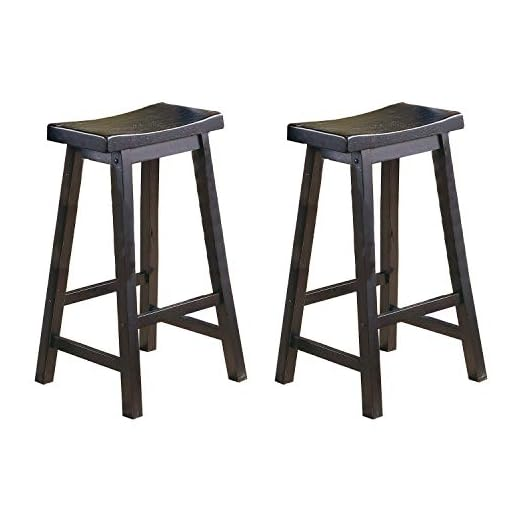

['bar stool', 'wood', 'black', 'saddle']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-846a-7281-b310-5b8c64140599


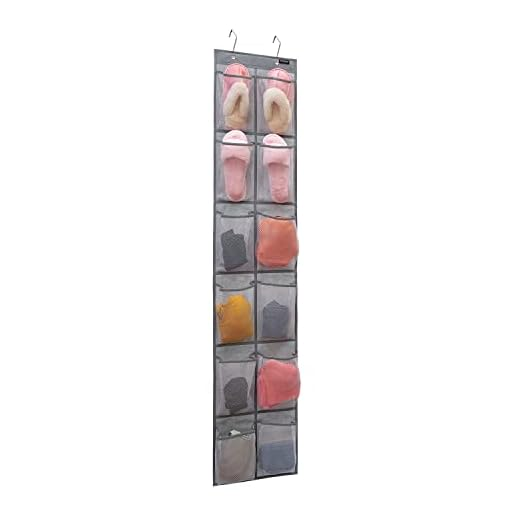

['shoe organizer', 'hanging', 'mesh', 'closet', 'storage', 'kids', 'pockets']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-8cb2-79a0-9f99-fb4bbc41a5b1


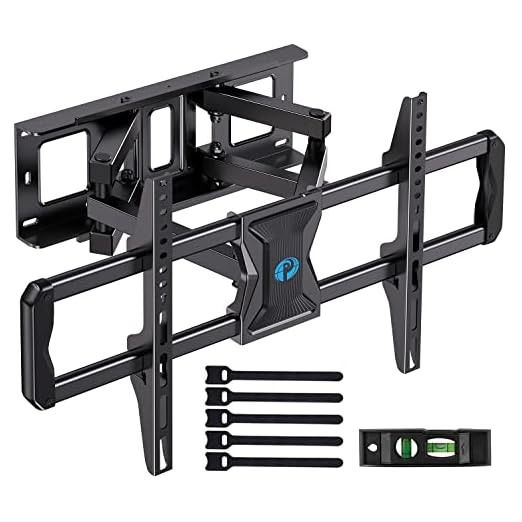

['tv wall mount', 'full-motion', 'metal', 'black']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-92d0-7152-a55c-04cef7c198a9


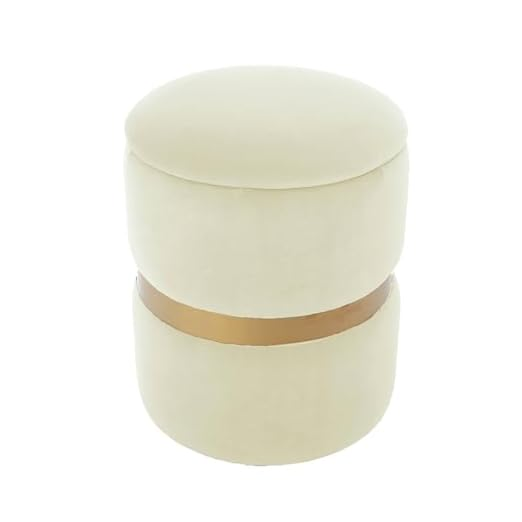

['ottoman', 'storage', 'velvet', 'ivory', 'modern']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-9a2d-7893-b5a7-c8bc592adb53


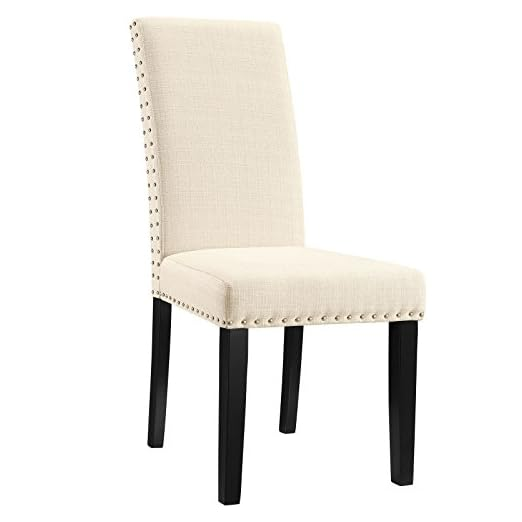

['chair', 'upholstered', 'fabric', 'beige', 'parsons']





In [6]:
# Initialize tracing with weave
weave.init("tag_caption_images")

for index, ex in examples.iterrows():
    url = ex['primary_image']
    results = gen_keywords(url, ex['title'])
    display(results["image"])
    print(results["keywords"])
    print("\n\n")

### Looking up existing keywords

Using embeddings to avoid duplicates (synonyms) and/or match pre-defined keywords

In [7]:
# Feel free to change the embedding model here
@weave.op
def get_embedding(value, model="text-embedding-3-large"): 
    embeddings = client.embeddings.create(
      model=model,
      input=value,
      encoding_format="float"
    )
    return {"embedding": embeddings.data[0].embedding}

#### Testing with example keywords

In [8]:
# Existing keywords
keywords_list = ['industrial', 'metal', 'wood', 'vintage', 'bed']

In [9]:
df_keywords = pd.DataFrame(keywords_list, columns=['keyword'])
df_keywords["embedding"] = df_keywords["keyword"].apply(
    lambda x: get_embedding(x)["embedding"]
)
df_keywords

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-a20d-7650-af62-83be1953c20d
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-a468-76c1-baca-e8db40c8aeb3
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-a597-79d1-b795-cd7719cae447
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-a7d7-75b2-ba8d-b1eb93fa03a8
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-a8e0-74d3-864e-1c1f898d21c5


,keyword,embedding
0,industrial,"[-0.026104676, 0.021315938, -0.007286835, -0.0..."
1,metal,"[-0.02048884, 0.0045095454, -0.011061306, -0.0..."
2,wood,"[0.013843054, 0.029607248, 0.0006022929, -0.03..."
3,vintage,"[-0.052451305, 0.0082121175, -0.015521124, 0.0..."
4,bed,"[-0.011725744, 0.02329314, 0.002695892, -0.010..."


In [10]:
@weave.op
def compare_keyword(keyword):
    embedded_value = get_embedding(keyword)["embedding"]
    df_keywords['similarity'] = df_keywords['embedding'].apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    most_similar = df_keywords.sort_values('similarity', ascending=False).iloc[0]
    return most_similar

@weave.op
def replace_keyword(keyword, threshold = 0.6):
    most_similar = compare_keyword(keyword)
    if most_similar['similarity'] > threshold:
        print(f"Replacing '{keyword}' with existing keyword: '{most_similar['keyword']}'")
        return most_similar['keyword']
    return keyword

In [11]:
# Example keywords to compare to our list of existing keywords
example_keywords = ['bed frame', 'wooden', 'vintage', 'old school', 'desk', 'table', 'old', 'metal', 'metallic', 'woody']
final_keywords = []

for k in example_keywords:
    final_keywords.append(replace_keyword(k))
    
final_keywords = set(final_keywords)
print(f"Final keywords: {final_keywords}")

Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: Val

Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


Replacing 'bed frame' with existing keyword: 'bed'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-abdb-7590-b0ec-f23b47b56757


Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


Replacing 'wooden' with existing keyword: 'wood'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-ad58-7af3-8425-12aeaa38082b


Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


Replacing 'vintage' with existing keyword: 'vintage'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-af22-76f0-8e03-aa4f312d946b


Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-b0bd-7120-a135-d3a197b7e59d
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-b53c-71f1-84ac-f81839a53cbb
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-b745-79c1-8340-76c1e393a015


Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-b8ea-7621-a9ad-d350b3ad0225


Task failed: ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


Replacing 'metal' with existing keyword: 'metal'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-bb31-7af2-99ea-f17ab96e9a0a
Replacing 'metallic' with existing keyword: 'metal'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-bc56-7420-b8bd-2f9c15a4e144
Replacing 'woody' with existing keyword: 'wood'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-be3a-76a3-9d91-68cfc523845e
Final keywords: {'vintage', 'desk', 'table', 'old school', 'wood', 'bed', 'metal', 'old'}


## Generate captions

In this section, we'll use GPT-4o mini to generate an image description and then use a few-shot examples approach with GPT-4-turbo to generate captions from the images.

If few-shot examples are not enough for your use case, consider fine-tuning a model to get the generated captions to match the style & tone you are targeting. 

In [12]:
# Cleaning up dataset columns
selected_columns = ['title', 'primary_image', 'style', 'material', 'color', 'url']
df = df[selected_columns].copy()
df.head()

,title,primary_image,style,material,color,url
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",https://m.media-amazon.com/images/I/416WaLx10j...,Modern,Metal,White,https://www.amazon.com/dp/B0CJHKVG6P
1,"subrtex Leather ding Room, Dining Chairs Set o...",https://m.media-amazon.com/images/I/31SejUEWY7...,Black Rubber Wood,Sponge,Black,https://www.amazon.com/dp/B0B66QHB23
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,https://m.media-amazon.com/images/I/41RgefVq70...,Modern,Polyethylene,Green,https://www.amazon.com/dp/B0BXRTWLYK
3,"Pickleball Doormat, Welcome Doormat Absorbent ...",https://m.media-amazon.com/images/I/61vz1Igler...,Modern,Rubber,A5589,https://www.amazon.com/dp/B0C1MRB2M8
4,JOIN IRON Foldable TV Trays for Eating Set of ...,https://m.media-amazon.com/images/I/41p4d4VJnN...,X Classic Style,Iron,Grey Set of 4,https://www.amazon.com/dp/B0CG1N9QRC


### Describing images with GPT-4o mini

In [13]:
describe_system_prompt = '''
    You are a system generating descriptions for furniture items, decorative items, or furnishings on an e-commerce website.
    Provided with an image and a title, you will describe the main item that you see in the image, giving details but staying concise.
    You can describe unambiguously what the item is and its material, color, and style if clearly identifiable.
    If there are multiple items depicted, refer to the title to understand which item you should describe.
    '''

@weave.op
def describe_image(img_url, title):
    response = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.2,
    messages=[
        {
            "role": "system",
            "content": describe_system_prompt
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": img_url,
                    }
                },
            ],
        },
        {
            "role": "user",
            "content": title
        }
    ],
    max_tokens=300,
    )

    return response.choices[0].message.content

#### Testing on a few examples

In [14]:
for index, row in examples.iterrows():
    print(f"{row['title'][:50]}{'...' if len(row['title']) > 50 else ''} - {row['url']} :\n")
    img_description = describe_image(row['primary_image'], row['title'])
    print(f"{img_description}\n--------------------------\n")

Lexicon Victoria Saddle Wood Bar Stools (Set of 2)... - https://www.amazon.com/dp/B08SLPBC36 :

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-bff2-7ff3-9e44-3c3ce4f0b087
The Lexicon Victoria Saddle Wood Bar Stools are a stylish set of two, featuring a sleek black sand finish. Each stool has a saddle-shaped seat for added comfort and a sturdy wooden frame with a height of 28.5 inches, making them ideal for bar or counter seating. The minimalist design complements various decor styles, adding a touch of elegance to any space.
--------------------------

ANZORG Behind Door Hanging Kids Shoes Organizer Cl... - https://www.amazon.com/dp/B09KN5ZTXC :

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56a-cf44-76d1-a251-af6195eea061
The ANZORG Behind Door Hanging Kids Shoes Organizer is a practical storage solution designed to maximize space. It features 12 mesh pockets, allowing for easy visibility and access to items. The organizer is ideal for storing shoes, acc

### Turning descriptions into captions
Using a few-shot examples approach to turn a long description into a short image caption

In [15]:
caption_system_prompt = '''
Your goal is to generate short, descriptive captions for images of furniture items, decorative items, or furnishings based on an image description.
You will be provided with a description of an item image and you will output a caption that captures the most important information about the item.
Your generated caption should be short (1 sentence), and include the most relevant information about the item.
The most important information could be: the type of the item, the style (if mentioned), the material if especially relevant and any distinctive features.
'''

few_shot_examples = [
    {
        "description": "This is a multi-layer metal shoe rack featuring a free-standing design. It has a clean, white finish that gives it a modern and versatile look, suitable for various home decors. The rack includes several horizontal shelves dedicated to organizing shoes, providing ample space for multiple pairs. Above the shoe storage area, there are 8 double hooks arranged in two rows, offering additional functionality for hanging items such as hats, scarves, or bags. The overall structure is sleek and space-saving, making it an ideal choice for placement in living rooms, bathrooms, hallways, or entryways where efficient use of space is essential.",
        "caption": "White metal free-standing shoe rack"
    },
    {
        "description": "The image shows a set of two dining chairs in black. These chairs are upholstered in a leather-like material, giving them a sleek and sophisticated appearance. The design features straight lines with a slight curve at the top of the high backrest, which adds a touch of elegance. The chairs have a simple, vertical stitching detail on the backrest, providing a subtle decorative element. The legs are also black, creating a uniform look that would complement a contemporary dining room setting. The chairs appear to be designed for comfort and style, suitable for both casual and formal dining environments.",
        "caption": "Set of 2 modern black leather dining chairs"
    },
    {
        "description": "This is a square plant repotting mat designed for indoor gardening tasks such as transplanting and changing soil for plants. It measures 26.8 inches by 26.8 inches and is made from a waterproof material, which appears to be a durable, easy-to-clean fabric in a vibrant green color. The edges of the mat are raised with integrated corner loops, likely to keep soil and water contained during gardening activities. The mat is foldable, enhancing its portability, and can be used as a protective surface for various gardening projects, including working with succulents. It's a practical accessory for garden enthusiasts and makes for a thoughtful gift for those who enjoy indoor plant care.",
        "caption": "Waterproof square plant repotting mat"
    }
]

formatted_examples = [[{
    "role": "user",
    "content": ex['description']
},
{
    "role": "assistant", 
    "content": ex['caption']
}]
    for ex in few_shot_examples
]

formatted_examples = [i for ex in formatted_examples for i in ex]

In [16]:
@weave.op
def caption_image(description, model="gpt-4o-mini"):
    messages = formatted_examples
    messages.insert(0, 
        {
            "role": "system",
            "content": caption_system_prompt
        })
    messages.append(
        {
            "role": "user",
            "content": description
        })
    response = client.chat.completions.create(
    model=model,
    temperature=0.2,
    messages=messages
    )

    return {"caption": response.choices[0].message.content}

#### Testing on a few examples

In [17]:
examples = df.iloc[5:8]

In [18]:
for index, row in examples.iterrows():
    print(f"{row['title'][:50]}{'...' if len(row['title']) > 50 else ''} - {row['url']} :\n")
    img_description = describe_image(row['primary_image'], row['title'])
    print(f"{img_description}\n--------------------------\n")
    img_caption = caption_image(img_description)["caption"]
    print(f"{img_caption}\n--------------------------\n")

LOVMOR 30'' Bathroom Vanity Sink Base Cabine, Stor... - https://www.amazon.com/dp/B0C9WYYFLB :

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56b-18cc-7480-8042-afa534bdd372
The LOVMOR 30'' Bathroom Vanity Sink Base Cabinet features a classic design with a rich brown finish. It includes three drawers on the left side for ample storage, complemented by two larger cabinet doors on the right. The cabinet is constructed with detailed paneling, adding a touch of elegance, making it suitable for bathrooms, kitchens, laundry rooms, and more. Its versatile style allows it to blend seamlessly into various decor themes.
--------------------------

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b56b-2b4a-7233-9050-59c39f0de14e
Classic 30'' brown bathroom vanity sink base cabinet with ample storage.
--------------------------

Folews Bathroom Organizer Over The Toilet Storage,... - https://www.amazon.com/dp/B09NZY3R1T :

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/c

## Image search

In this section, we will use generated keywords and captions to search items that match a given input, either text or image.

We will leverage our embeddings model to generate embeddings for the keywords and captions and compare them to either input text or the generated caption from an input image.

In [19]:
# Df we'll use to compare keywords
df_keywords = pd.DataFrame(columns=['keyword', 'embedding'])
df['keywords'] = ''
df['img_description'] = ''
df['caption'] = ''

In [20]:
# Function to replace a keyword with an existing keyword if it's too similar
@weave.op
def get_keyword(keyword, df_keywords, threshold = 0.6):
    embedded_value = get_embedding(keyword)
    df_keywords['similarity'] = df_keywords['embedding'].apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    sorted_keywords = df_keywords.copy().sort_values('similarity', ascending=False)
    if len(sorted_keywords) > 0 :
        most_similar = sorted_keywords.iloc[0]
        if most_similar['similarity'] > threshold:
            print(f"Replacing '{keyword}' with existing keyword: '{most_similar['keyword']}'")
            return most_similar['keyword']
    new_keyword = {
        'keyword': keyword,
        'embedding': embedded_value
    }
    df_keywords = pd.concat([df_keywords, pd.DataFrame([new_keyword])], ignore_index=True)
    return {"keyword": keyword}

### Preparing the dataset

In [21]:
import ast

@weave.op
def tag_and_caption(row):
    keywords = gen_keywords(row['primary_image'], row['title'])["keywords"]
    try:
        keywords = ast.literal_eval(keywords)
        mapped_keywords = [get_keyword(k, df_keywords)["keyword"] for k in keywords]
    except Exception as e:
        print(f"Error parsing keywords: {keywords}")
        mapped_keywords = []
    img_description = describe_image(row['primary_image'], row['title'])
    caption = caption_image(img_description)["caption"]
    return {
        'keywords': mapped_keywords,
        'img_description': img_description,
        'caption': caption
    }


In [22]:
df.shape

(312, 9)

Processing all 312 lines of the dataset will take a while.
To test out the idea, we will only run it on the first 10 lines. 
Feel free to skip this step and load the already processed dataset (see below).

In [25]:
# Running on first 10 lines
items = 10
for index, row in df[:items].iterrows():
    print(
        f"{index} - {row['title'][:items]}{'...' if len(row['title']) > items else ''}"
    )
    updates = tag_and_caption(row)
    df.loc[index, updates.keys()] = updates.values()

0 - GOYMFK 1pc...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b570-40e9-7a60-b6ff-f6c492f53ca0
1 - subrtex Le...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b570-6cff-7b13-94ea-530f064801f6
2 - Plant Repo...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b570-8a69-7a01-9b63-ffa044146aaa
3 - Pickleball...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b570-c4d8-7193-b636-f37435d9a61e
4 - JOIN IRON ...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b570-eb91-7913-bbac-f58c2ec35494
5 - LOVMOR 30'...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b571-1703-7f80-9c8e-60a79054fa5d
6 - Folews Bat...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b571-3d85-75c2-90d3-280d8f585d98
7 - GOYMFK 1pc...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b571-6df2-7b91-b79f-15675cbc5e9b
8 - subrtex Le...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b571-8fb6-7fc2-99f5-5ec795123df8
9 - Plant 

In [24]:
df.head()

,title,primary_image,style,material,color,url,keywords,img_description,caption
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",https://m.media-amazon.com/images/I/416WaLx10j...,Modern,Metal,White,https://www.amazon.com/dp/B0CJHKVG6P,"[shoe rack, metal, white, multi-layer, hooks]",The GOYMFK Free Standing Shoe Rack is a versat...,Sleek white multi-layer metal free-standing sh...
1,"subrtex Leather ding Room, Dining Chairs Set o...",https://m.media-amazon.com/images/I/31SejUEWY7...,Black Rubber Wood,Sponge,Black,https://www.amazon.com/dp/B0B66QHB23,"[dining chair, leather, black]",The Subrtex Leather Dining Chairs are a stylis...,Set of 2 modern black faux leather dining chai...
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,https://m.media-amazon.com/images/I/41RgefVq70...,Modern,Polyethylene,Green,https://www.amazon.com/dp/B0BXRTWLYK,"[repotting mat, waterproof, gardening, portabl...","The Plant Repotting Mat is a waterproof, porta...",Waterproof portable plant repotting mat with v...
3,"Pickleball Doormat, Welcome Doormat Absorbent ...",https://m.media-amazon.com/images/I/61vz1Igler...,Modern,Rubber,A5589,https://www.amazon.com/dp/B0C1MRB2M8,"[doormat, absorbent, non-slip, welcome, cork, ...",This Pickleball Doormat features a natural coi...,"Natural coir doormat with a playful ""It's a go..."
4,JOIN IRON Foldable TV Trays for Eating Set of ...,https://m.media-amazon.com/images/I/41p4d4VJnN...,X Classic Style,Iron,Grey Set of 4,https://www.amazon.com/dp/B0CG1N9QRC,"[tv tray, foldable, metal, grey]",The JOIN IRON Foldable TV Tray Set includes fo...,The JOIN IRON Foldable TV Tray Set features fo...


In [53]:
data_path = "data/items_tagged_and_captioned.csv"

In [54]:
# Saving locally for later - optional: do not execute if you prefer to use the provided file
df.to_csv(data_path, index=False)

In [55]:
# Optional: load data from saved file if you haven't processed the whole dataset
df = pd.read_csv(data_path)

### Embedding captions and keywords
We can now use the generated captions and keywords to match relevant content to an input text query or caption. 
To do this, we will embed a combination of keywords + captions.
Note: creating the embeddings will take ~3 mins to run. Feel free to load the pre-processed dataset (see below).

In [56]:
df_search = df.copy()

In [57]:
def embed_tags_caption(x):
    if x['caption'] != '':
        try:
            keywords_string = ",".join(k for k in x['keywords']) + '\n'
            content = keywords_string + x['caption']
            embedding = get_embedding(content)
            return embedding
        except Exception as e:
            print(f"Error creating embedding for {x}: {e}")

In [ ]:
df_search['embedding'] = df_search.apply(lambda x: embed_tags_caption(x), axis=1)

In [ ]:
df_search.head()

In [ ]:
# Keep only the lines where we have embeddings
df_search = df_search.dropna(subset=['embedding'])
print(df_search.shape)

In [61]:
data_embeddings_path = "data/items_tagged_and_captioned_embeddings.csv"

In [62]:
# Saving locally for later - optional: do not execute if you prefer to use the provided file
df_search.to_csv(data_embeddings_path, index=False)

In [63]:
# Optional: load data from saved file if you haven't processed the whole dataset
from ast import literal_eval
df_search = pd.read_csv(data_embeddings_path)
df_search["embedding"] = df_search.embedding.apply(literal_eval).apply(np.array)

### Search from input text    

We can compare the input text from a user directly to the embeddings we just created.

In [64]:
# Searching for N most similar results
def search_from_input_text(query, n = 2):
    embedded_value = get_embedding(query)
    df_search['similarity'] = df_search['embedding'].apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    most_similar = df_search.sort_values('similarity', ascending=False).iloc[:n]
    return most_similar

In [65]:
user_inputs = ['shoe storage', 'black metal side table', 'doormat', 'step bookshelf', 'ottoman']

In [ ]:
for i in user_inputs:
    print(f"Input: {i}\n")
    res = search_from_input_text(i)
    for index, row in res.iterrows():
        similarity_score = row['similarity']
        if isinstance(similarity_score, np.ndarray):
            similarity_score = similarity_score[0][0]
        print(f"{row['title'][:50]}{'...' if len(row['title']) > 50 else ''} ({row['url']}) - Similarity: {similarity_score:.2f}")
        img = Image(url=row['primary_image'])
        display(img)
        print("\n\n")

### Search from image

If the input is an image, we can find similar images by first turning images into captions, and embedding those captions to compare them to the already created embeddings.

In [67]:
# We'll take a mix of images: some we haven't seen and some that are already in the dataset
example_images = df.iloc[306:]['primary_image'].to_list() + df.iloc[5:10]['primary_image'].to_list()

In [ ]:
for i in example_images:
    img_description = describe_image(i, '')
    caption = caption_image(img_description)["caption"]
    img = Image(url=i)
    print('Input: \n')
    display(img)
    res = search_from_input_text(caption, 1).iloc[0]
    similarity_score = res['similarity']
    if isinstance(similarity_score, np.ndarray):
        similarity_score = similarity_score[0][0]
    print(f"{res['title'][:50]}{'...' if len(res['title']) > 50 else ''} ({res['url']}) - Similarity: {similarity_score:.2f}")
    img_res = Image(url=res['primary_image'])
    display(img_res)
    print("\n\n")
    

## Wrapping up


In this notebook, we explored how to leverage the multimodal capabilities of `gpt-4o-mini` to tag and caption images. By providing images along with contextual information to the model, we were able to generate tags and descriptions that can be further refined to create captions. This process has practical applications in various scenarios, particularly in enhancing search functionalities.

The search use case illustrated can be directly applied to applications such as recommendation systems, but the techniques covered in this notebook can be extended beyond items search and used in multiple use cases, for example RAG applications leveraging unstructured image data.

As a next step, you could explore using a combination of rule-based filtering with keywords and embeddings search with captions to retrieve more relevant results.